In [4]:
import os

import matplotlib
import matplotlib.pyplot as plt

import colorsys

import pandas as pd

from sklearn import metrics

import seaborn as sns


sns.set_context("paper", font_scale=1.2)

style="whitegrid"
rc={"axes.facecolor": "0.99",
    "grid.color": "0.95",
    "axes.edgecolor": "0.90"}

datadir = "../data"
savedir = "figs"

if not os.path.exists(savedir):
    os.makedirs(savedir)

print("reading data...", end="")
el = pd.read_csv(os.path.join(datadir, "el.csv"))
eltrain = pd.read_csv(os.path.join(datadir, "el_train.csv"))
imtrain = pd.read_csv(os.path.join(datadir, "im_train.csv"))
neg = pd.read_csv(os.path.join(datadir, "neg.csv"))
iedb = pd.read_csv(os.path.join(datadir, "iedb.csv"))
ifng = pd.read_csv(os.path.join(datadir, "ifng.csv"))
manafest = pd.read_csv(os.path.join(datadir, "manafest.csv"))
print("done")

methods = {
    "bigmhc_el"  : "BigMHC EL",
    "bigmhc_im"  : "BigMHC IM",
    "mhcnuggets" : "MHCnuggets-2.3.2",
    "mhcflurry"  : "MHCflurry-2.0",
    "netmhcpan"  : "NetMHCpan-4.1",
    "mixmhcpred" : "MixMHCpred-2.1",
    "prime"      : "PRIME",
    "transphla"  : "TransPHLA"
}

colors = {
    "BigMHC EL"        : "mediumpurple",
    "BigMHC IM"        : "rebeccapurple",
    "MHCnuggets-2.3.2" : "palevioletred",
    "MHCflurry-2.0"    : "cornflowerblue",
    "NetMHCpan-4.1"    : "sandybrown",
    "MixMHCpred-2.1"   : "darkseagreen",
    "PRIME"            : "mediumseagreen",
    "TransPHLA"        : "salmon"
}

reading data...done


In [5]:
def auprc(T,P):
    ppv, tpr, _ = metrics.precision_recall_curve(T, P)
    return metrics.auc(tpr, ppv)


def violins(
    ax,
    results,
    title,
    metricname,
    order,
    setylabel):
    
    sns.violinplot(
        ax=ax,
        data=results,
        x="Method",
        y=metricname,
        cut=0,
        width=0.95,
        linewidth=1,
        scale="width",
        palette=colors,
        order=order)
    
    ax.set(xlabel=None)
    
    ylim = [0, min(1, results[metricname].max() * 1.1)]
    if metricname=="AUROC":
        ylim[0] = min(0.45, results[metricname].min() * 0.9)
    ax.set(ylim=ylim)
        
    ax.tick_params(axis='x', rotation=90)
    
    ax.set(title=title)
    
    if not setylabel:
        ax.set(ylabel=None)
    
    for x,c in enumerate(ax.collections):
        if not (x % 2):
            rgb = c.get_facecolor()[0][:3]
            hls = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
            c.set_edgecolor(colorsys.hls_to_rgb(hls[0], hls[1]/2, hls[2]))

In [3]:
def vizDatasets(dfs, titles):
    
    fig = plt.figure(figsize=(20,28), dpi=400)
    gs = fig.add_gridspec(nrows=len(dfs), ncols=4, hspace=0.20)
    ax = gs.subplots()
    
    barcolors = ["crimson", "navy"]
    
    for y,df in enumerate(dfs):
        
        if y < len(dfs) - 1:
            xlabel0 = None
            xlabel1 = None
        else:
            xlabel0 = "MHC Supertype"
            xlabel1 = "Epitope Length"
        
        if not y:
            ax[y][0].set_title("Positives")
            ax[y][1].set_title("Negatives")
            ax[y][2].set_title("Positives")
            ax[y][3].set_title("Negatives")
    
        df["grp"] = df["mhc"].apply(lambda x: x[x.index('*')-1])
        grp = df.groupby("grp")
        D = pd.DataFrame({"pos":grp.tgt.sum()}, index=grp.groups.keys())
        D.plot.bar(ax=ax[y][0], xlabel=xlabel0, ylabel=titles[y], color=barcolors[0], legend=None, width=0.75)
        D = pd.DataFrame({"neg":grp.tgt.count()-grp.tgt.sum()}, index=grp.groups.keys())
        D.plot.bar(ax=ax[y][1], xlabel=xlabel0, color=barcolors[1], legend=None, width=0.75)

        df["grp"] = df["pep"].apply(len)
        grp = df.groupby("grp")
        D = pd.DataFrame({"pos":grp.tgt.sum()}, index=grp.groups.keys())
        D.plot.bar(ax=ax[y][2], xlabel=xlabel1, color=barcolors[0], legend=None, width=0.75)
        D = pd.DataFrame({"neg":grp.tgt.count()-grp.tgt.sum()}, index=grp.groups.keys())
        D.plot.bar(ax=ax[y][3], xlabel=xlabel1, color=barcolors[1], legend=None, width=0.75)
        
        for col in range(4):
            ax[y][col].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
            ax[y][col].grid(axis='x')
        
    return fig


with sns.axes_style(style=style, rc=rc):
    datafig = vizDatasets(
        [eltrain,
         el,
         imtrain,
         pd.concat((ifng, manafest, neg)),
         iedb,
         ifng,
         manafest],
        ["Eluted Ligand Training",
         "Eluted Ligand Evaluation",
         "Immunogenicity Training",
         "Neoantigen Evaluation Dataset",
         "IEDB Infectious Disease Antigens",
         "IFN-γ Release Neoantigens",
         "MANAFEST Neoantigens"])
    datafig.suptitle("Composition of Datasets", fontsize=20, y=0.90)
    datafig.savefig(os.path.join(savedir,"datasets.png"), bbox_inches="tight")

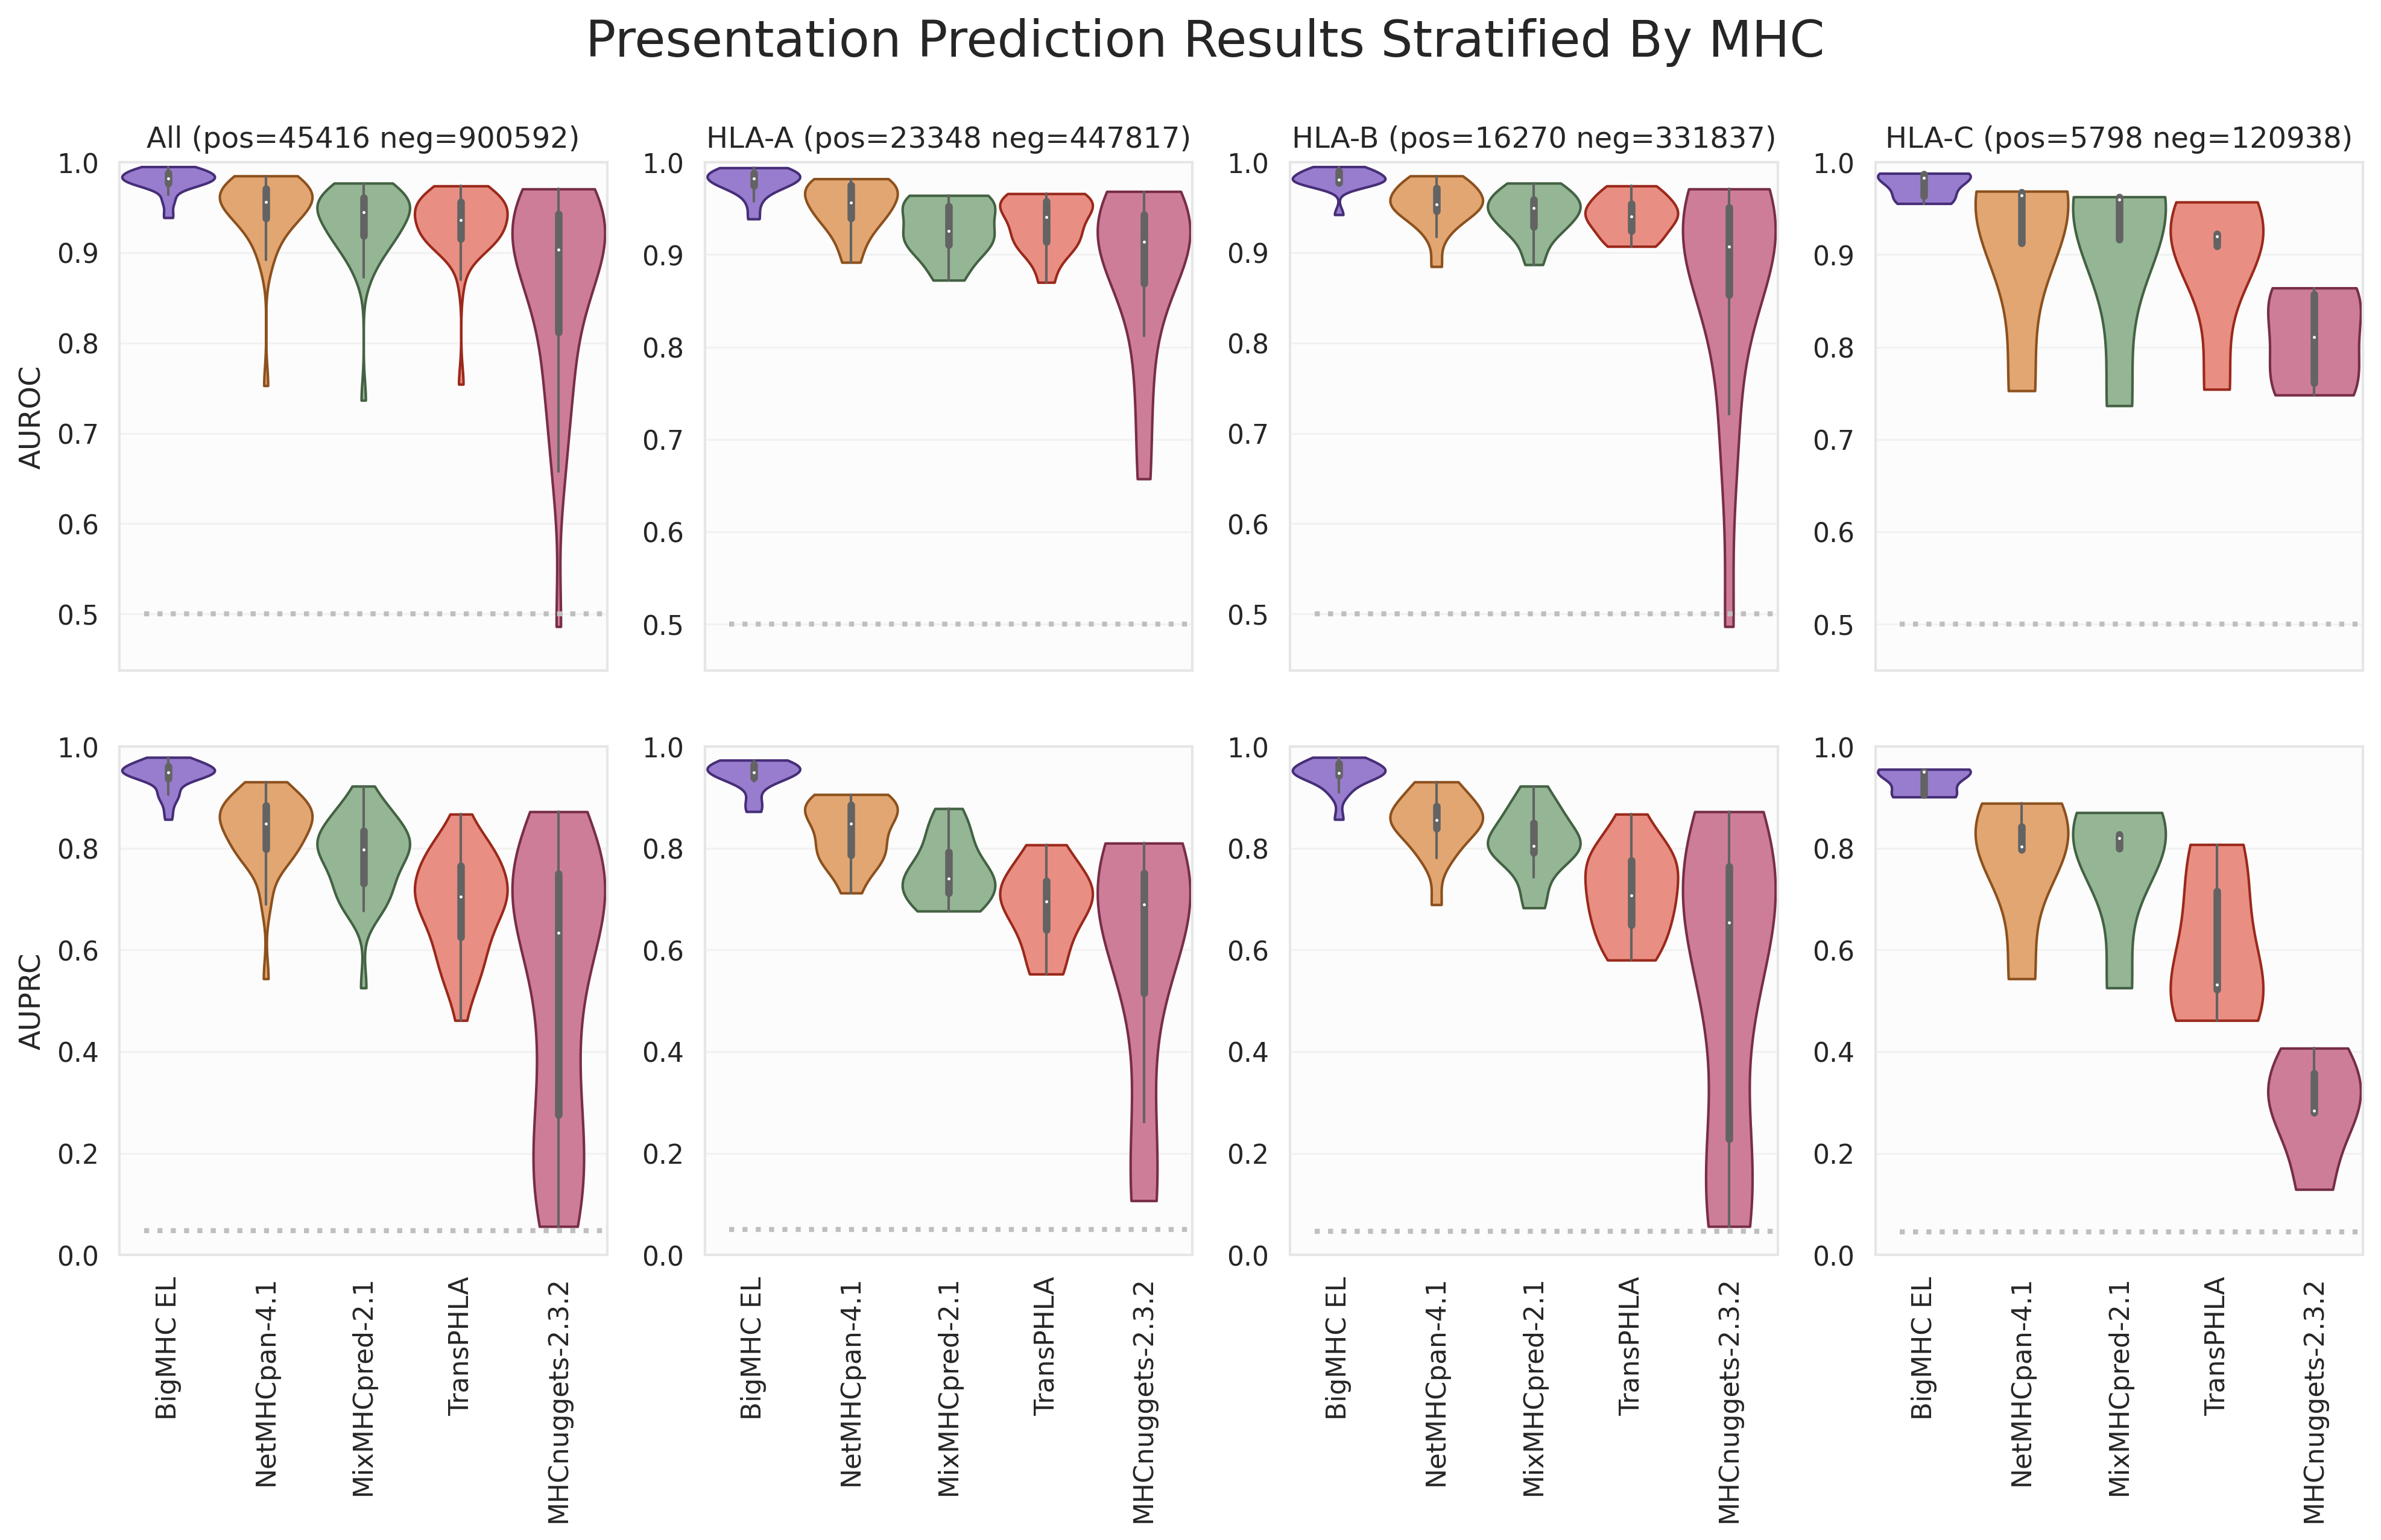

In [4]:
def plotELviolins(
    ax,
    df,
    title,
    metricfunc,
    metricname,
    setylabel):
    
    mhcgrp = df.groupby("mhc")
    algos  = [x for x in df.columns if x in methods]
    results = list()
    
    for mhc in mhcgrp.groups:
        grp = mhcgrp.get_group(mhc).copy()
        T = grp["tgt"].copy().to_numpy()
        for algo in algos:
            P = grp[algo].copy().to_numpy()
            results.append([mhc, metricfunc(T, P), methods[algo]])
    
    results = pd.DataFrame(
        columns=["MHC", metricname, "Method"],
        data=results)
    
    order = [
        methods["bigmhc_el"],
        methods["netmhcpan"],
        methods["mixmhcpred"],
        methods["transphla"],
        methods["mhcnuggets"]]
    
    if metricfunc==metrics.roc_auc_score:
        y = 0.5
    else:
        y = df["tgt"].sum() / df.shape[0]
    x = [-0.25,len(order)-0.25]
    ax.plot(x,[y,y],color="0.75",linestyle=":",linewidth=2)
    
    violins(
        ax=ax,
        results=results,
        title=title,
        metricname=metricname,
        order=order,
        setylabel=setylabel)


with sns.axes_style(style=style, rc=rc):
    
    ela = el[el["mhc"].apply(lambda x: x.startswith("HLA-A"))]
    elb = el[el["mhc"].apply(lambda x: x.startswith("HLA-B"))]
    elc = el[el["mhc"].apply(lambda x: x.startswith("HLA-C"))]

    elfig = plt.figure(figsize=(16,8), dpi=300)

    gs = elfig.add_gridspec(nrows=2, ncols=4, hspace=0.15)
    ax = gs.subplots(sharex=True)

    dfs = [el, ela, elb, elc]

    titles = [
        "All (pos={} neg={})".format(
            int(el["tgt"].sum()),
            int(el.shape[0]-el["tgt"].sum())),
        "HLA-A (pos={} neg={})".format(
            int(ela["tgt"].sum()),
            int(ela.shape[0]-ela["tgt"].sum())),
        "HLA-B (pos={} neg={})".format(
            int(elb["tgt"].sum()),
            int(elb.shape[0]-elb["tgt"].sum())),
        "HLA-C (pos={} neg={})".format(
            int(elc["tgt"].sum()),
            int(elc.shape[0]-elc["tgt"].sum()))]

    for x in range(4):
            plotELviolins(
                ax=ax[0][x],
                df=dfs[x],
                title=titles[x],
                metricfunc=metrics.roc_auc_score,
                metricname="AUROC",
                setylabel=(x==0))
            plotELviolins(
                ax=ax[1][x],
                df=dfs[x],
                title=None,
                metricfunc=auprc,
                metricname="AUPRC",
                setylabel=(x==0))

    elfig.suptitle("Presentation Prediction Results Stratified By MHC", fontsize=20)

    elfig.savefig(os.path.join(savedir,"el_strat_mhc.png" ), bbox_inches="tight")

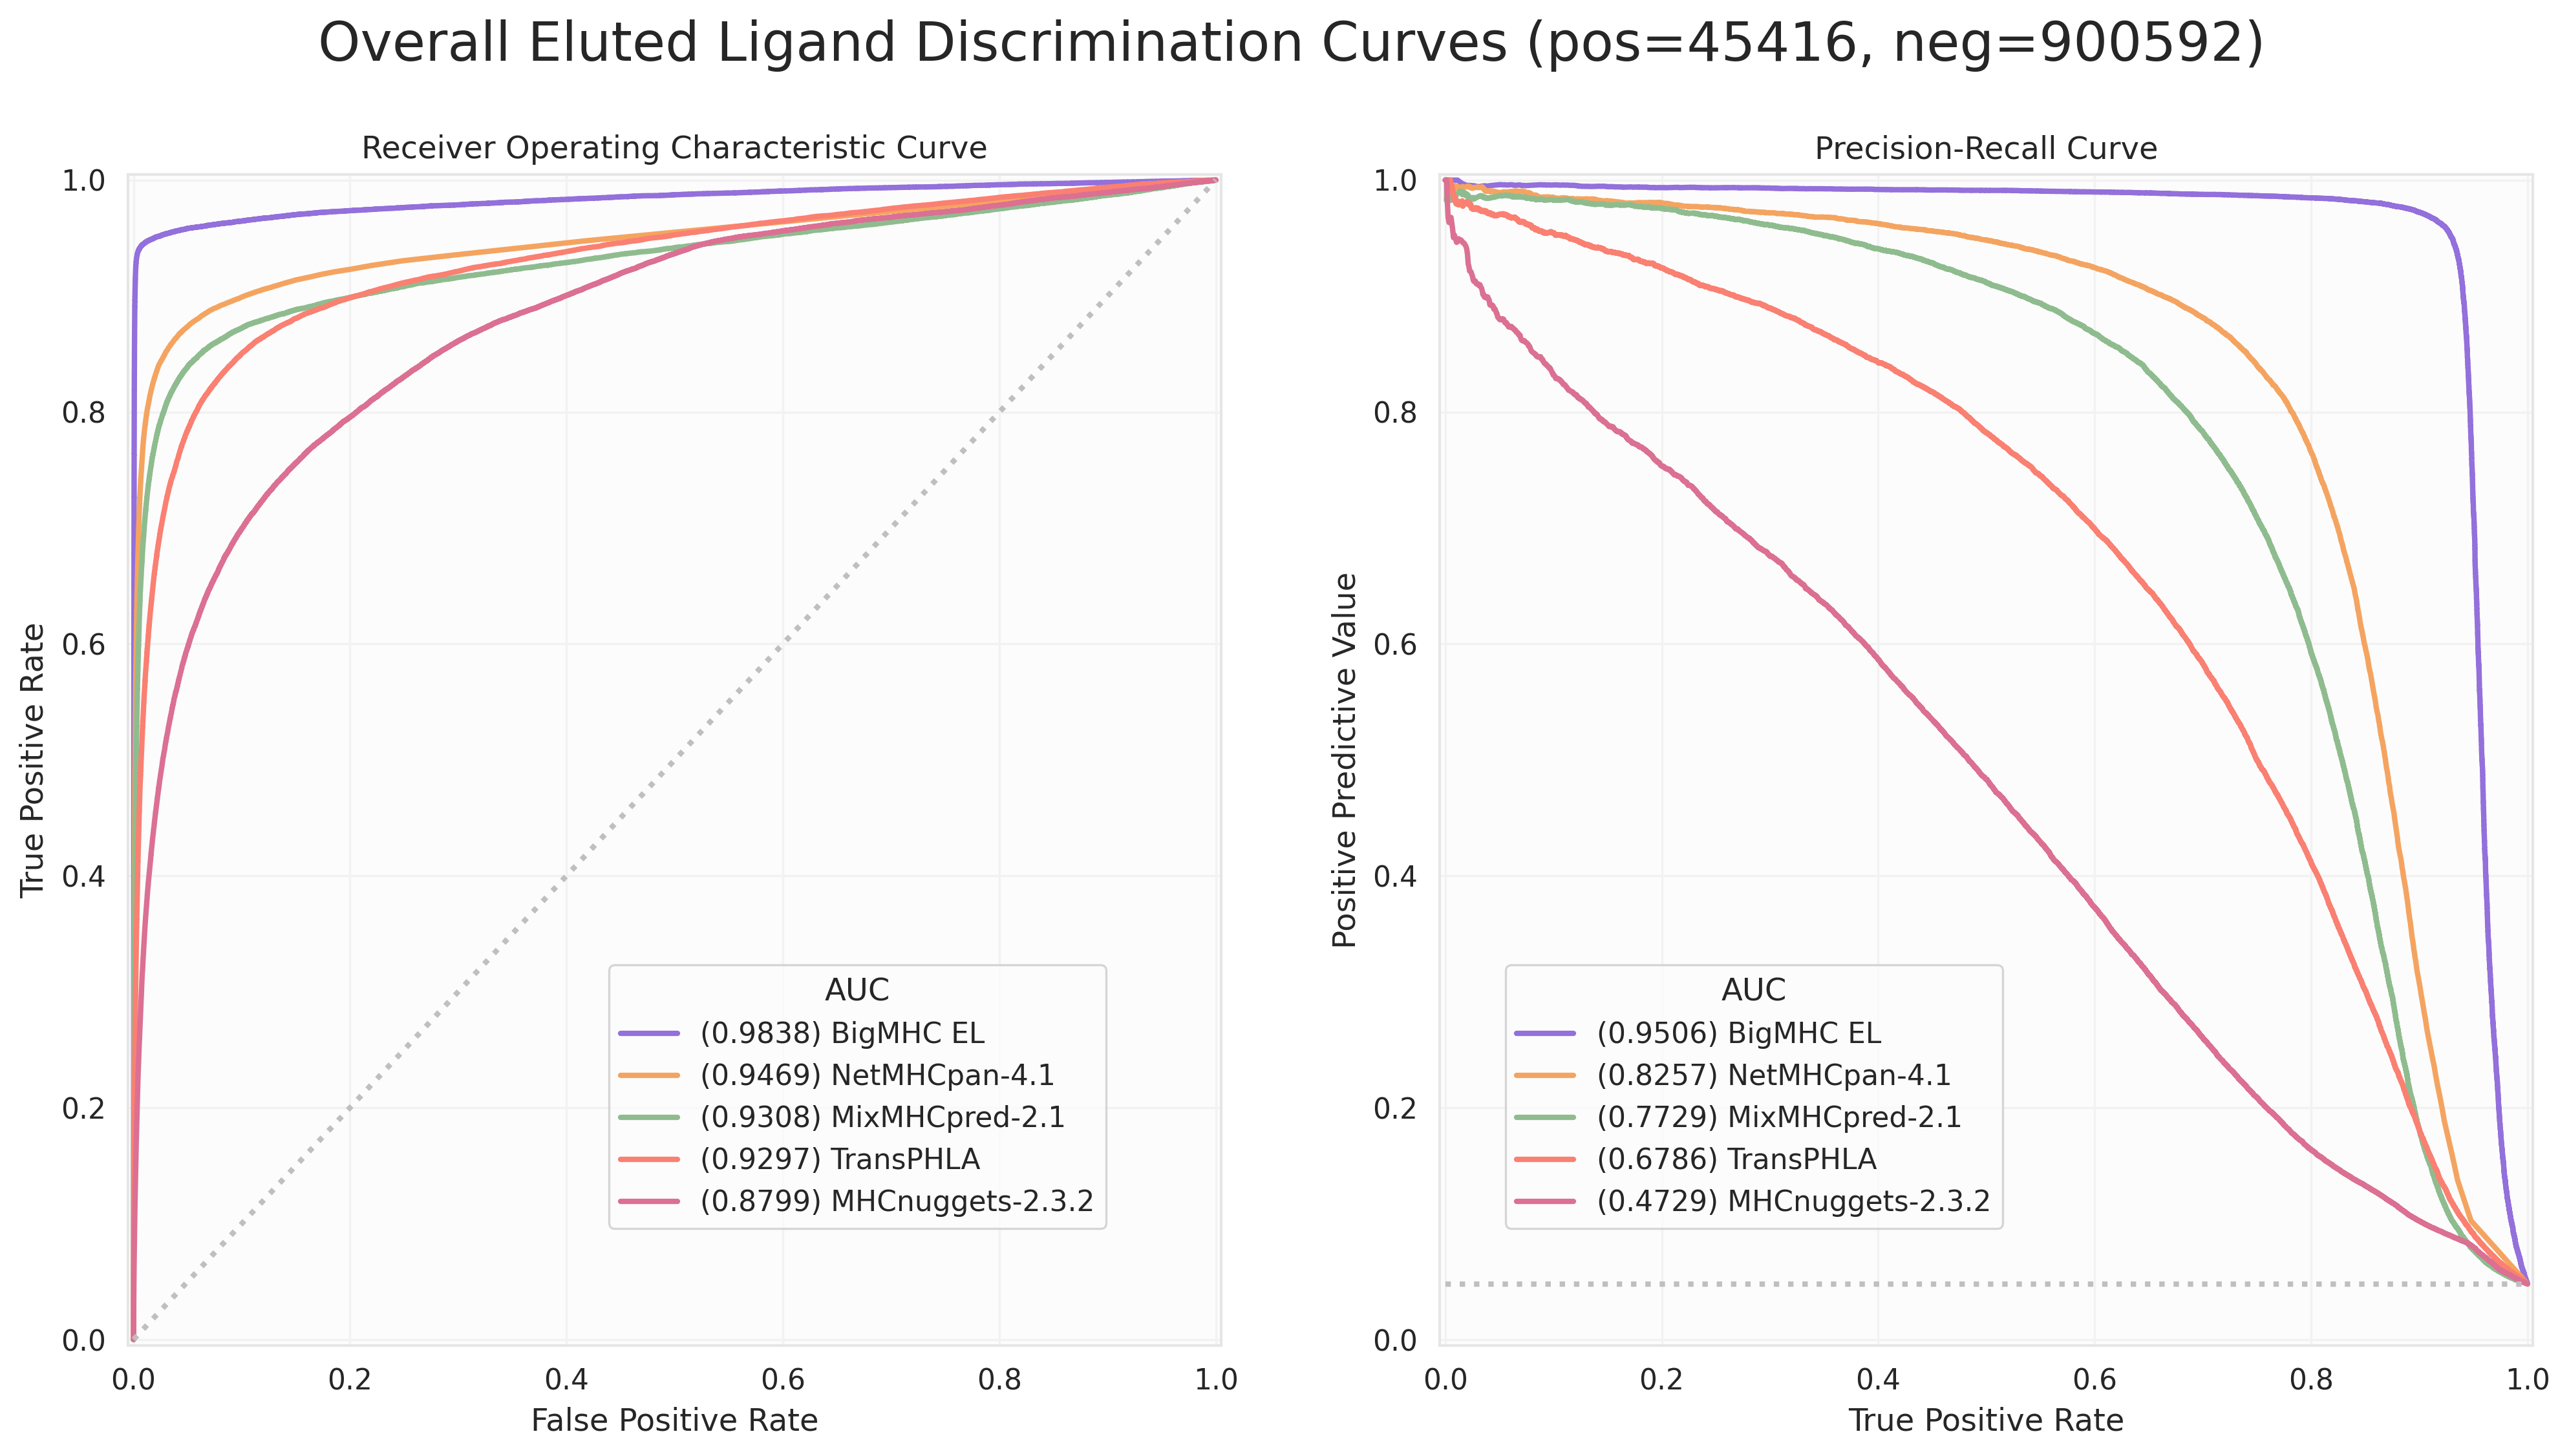

In [5]:
def plotELcurves(ax, df, roc):
    
    results = list()
    
    miny = 1
    
    order = [
        "bigmhc_el",
        "netmhcpan",
        "mixmhcpred",
        "transphla",
        "mhcnuggets"]
    
    for col in order:
        if roc:
            x, y, _ = metrics.roc_curve(df["tgt"], df[col])
        else:
            y, x, _ = metrics.precision_recall_curve(df["tgt"], df[col])
            miny = min(miny,min(y))
        label = "({:0.4f}) {}".format(metrics.auc(x,y), methods[col])
        ax.plot(x,y,color=colors[methods[col]],linewidth=2,label=label)
    
    if roc:
        ax.plot([0,1],[0,1],color="0.75",linestyle=":",linewidth=2)
        ax.set_title("Receiver Operating Characteristic Curve")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
    else:
        ax.plot([0,1],[miny,miny],color="0.75",linestyle=":",linewidth=2)
        ax.set_title("Precision-Recall Curve")
        ax.set_xlabel("True Positive Rate")
        ax.set_ylabel("Positive Predictive Value")
        
    
    ax.set_xlim([-0.005,1.005])
    ax.set_ylim([-0.005,1.005])
    
    if roc:
        ax.legend(title="AUC", loc=(0.44,0.1))
    else:
        ax.legend(title="AUC", loc=(0.06,0.1))


with sns.axes_style(style=style, rc=rc):

    elcurves = plt.figure(figsize=(16,8), dpi=300)

    gs = elcurves.add_gridspec(nrows=1, ncols=2, hspace=0.15)
    ax = gs.subplots(sharex=True)

    plotELcurves(ax[0], el, True)
    plotELcurves(ax[1], el, False)

    elcurves.suptitle("Overall Eluted Ligand Discrimination Curves (pos={}, neg={})".format(
        el["tgt"].sum(), len(el) - el["tgt"].sum()), fontsize=20)

    elcurves.savefig( os.path.join(savedir,"el_curves.png" ), bbox_inches="tight")

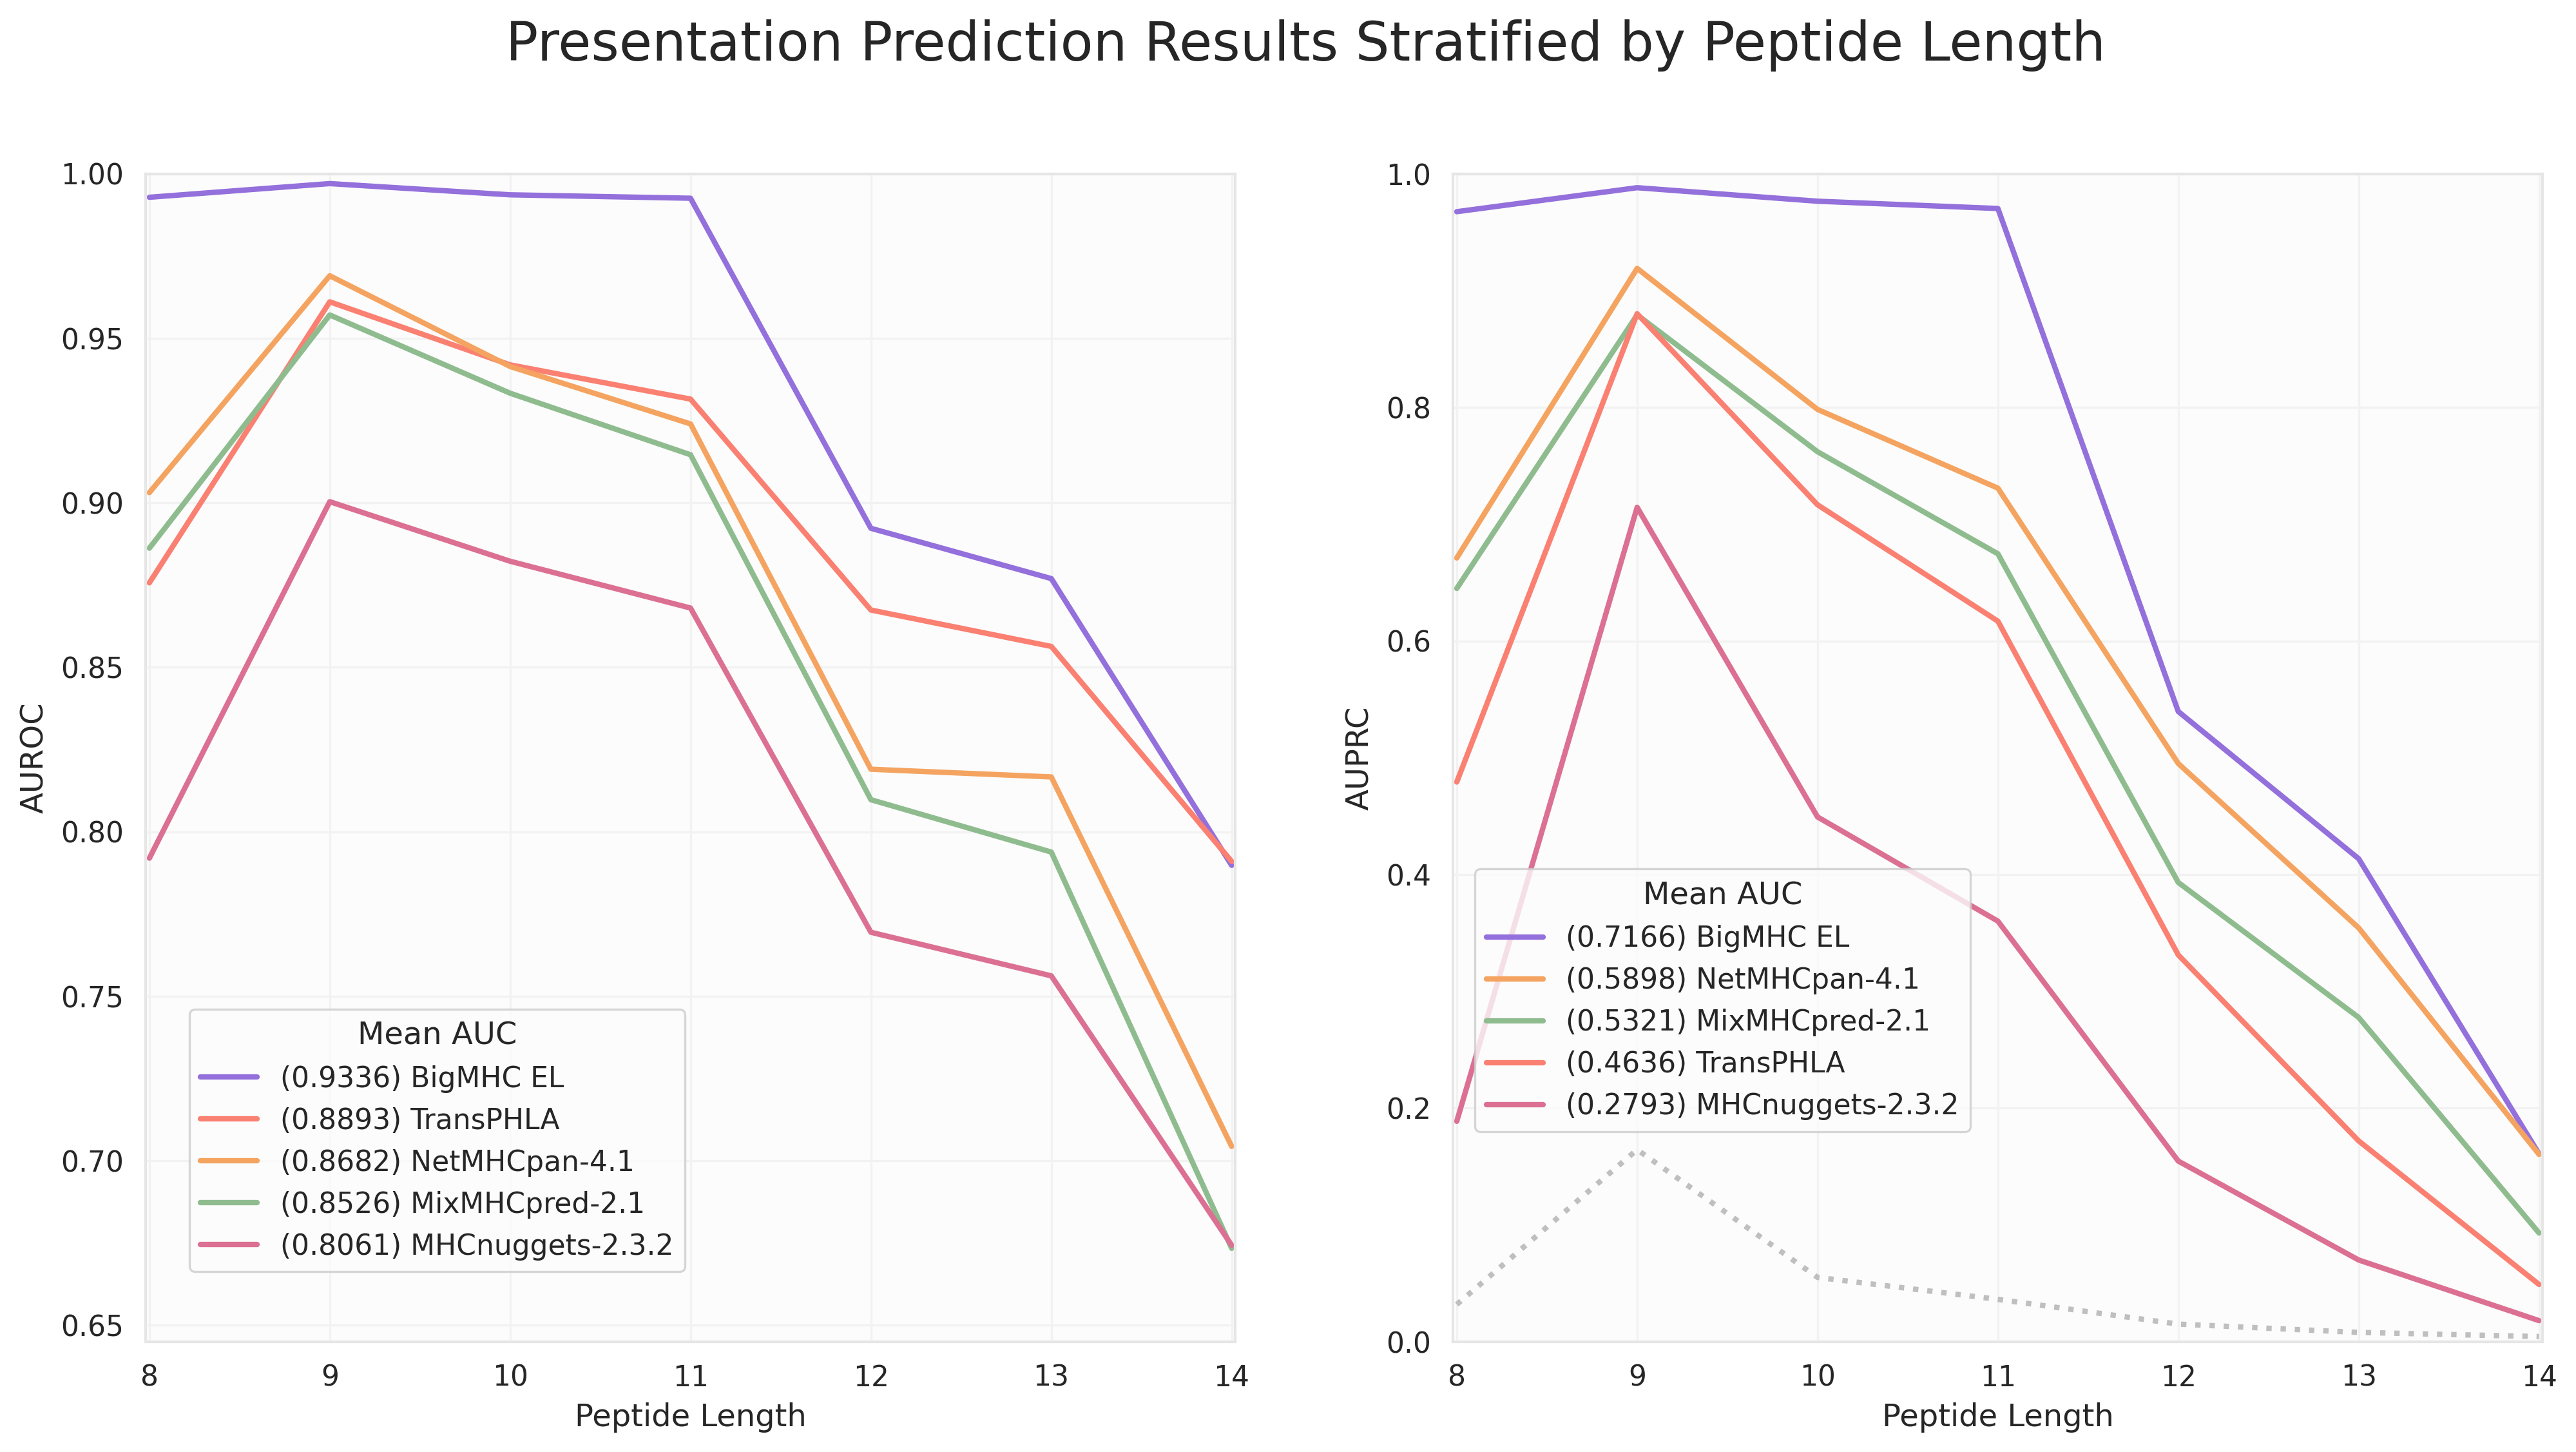

In [6]:
def plotELlines(ax, elL, roc):
    
    if roc:
        order = [
            "bigmhc_el",
            "transphla",
            "netmhcpan",
            "mixmhcpred",
            "mhcnuggets"]
    else:
        order = [
            "bigmhc_el",
            "netmhcpan",
            "mixmhcpred",
            "transphla",
            "mhcnuggets"]
    
    results = list()
    miny = 0.65
    
    means = {k:list() for k in order}
    
    for df in elL:
        for col in order:
            if roc:
                x, y, _ = metrics.roc_curve(df["tgt"], df[col])
            else:
                y, x, _ = metrics.precision_recall_curve(df["tgt"], df[col])
                miny = min(miny,min(y))
            auc = metrics.auc(x,y)
            means[col].append(auc)
            results.append([len(df["pep"].iloc[0]), auc, methods[col]])
    
    results = pd.DataFrame(
        columns=["Peptide Length", "AUROC" if roc else "AUPRC", "Method"],
        data=results)
    
    means = {k:sum(v)/len(v) for k,v in means.items()}
    labels = {methods[k]:"({:0.4f}) {}".format(v,methods[k]) for k,v in means.items()}
    
    ax.set_xlim([7.98,14.02])
    ax.set_ylim([max(0,miny-0.005),1])
    
    sns.lineplot(
        ax=ax,
        data=results,
        x=results.columns[0],
        y=results.columns[1],
        hue=results.columns[2],
        linewidth=2,
        palette=colors)
    
    if roc:
        loc = (0.04,0.06)
    else:
        loc = (0.02,0.18)
        baselinex = []
        baseliney = []
        for df in elL:
            baselinex.append(len(df["pep"].iloc[0]))
            baseliney.append(df["tgt"].sum() / df.shape[0])
        ax.plot(baselinex,baseliney,color="0.75",linestyle=":",linewidth=2)
        
    labels = [labels[t.get_text()] for t in ax.get_legend().texts]
    ax.legend(title="Mean AUC", loc=loc, labels=labels)


with sns.axes_style(style=style, rc=rc):
    
    elL = [el[el["pep"].apply(len)==x] for x in range(8,15)]
    
    ellines = plt.figure(figsize=(16,8), dpi=300)

    gs = ellines.add_gridspec(nrows=1, ncols=2, hspace=0.15)
    ax = gs.subplots(sharex=True)

    plotELlines(ax[0], elL, True)
    plotELlines(ax[1], elL, False)

    ellines.suptitle("Presentation Prediction Results Stratified by Peptide Length", fontsize=20)

    ellines.savefig(os.path.join(savedir,"el_strat_len.png" ), bbox_inches="tight")

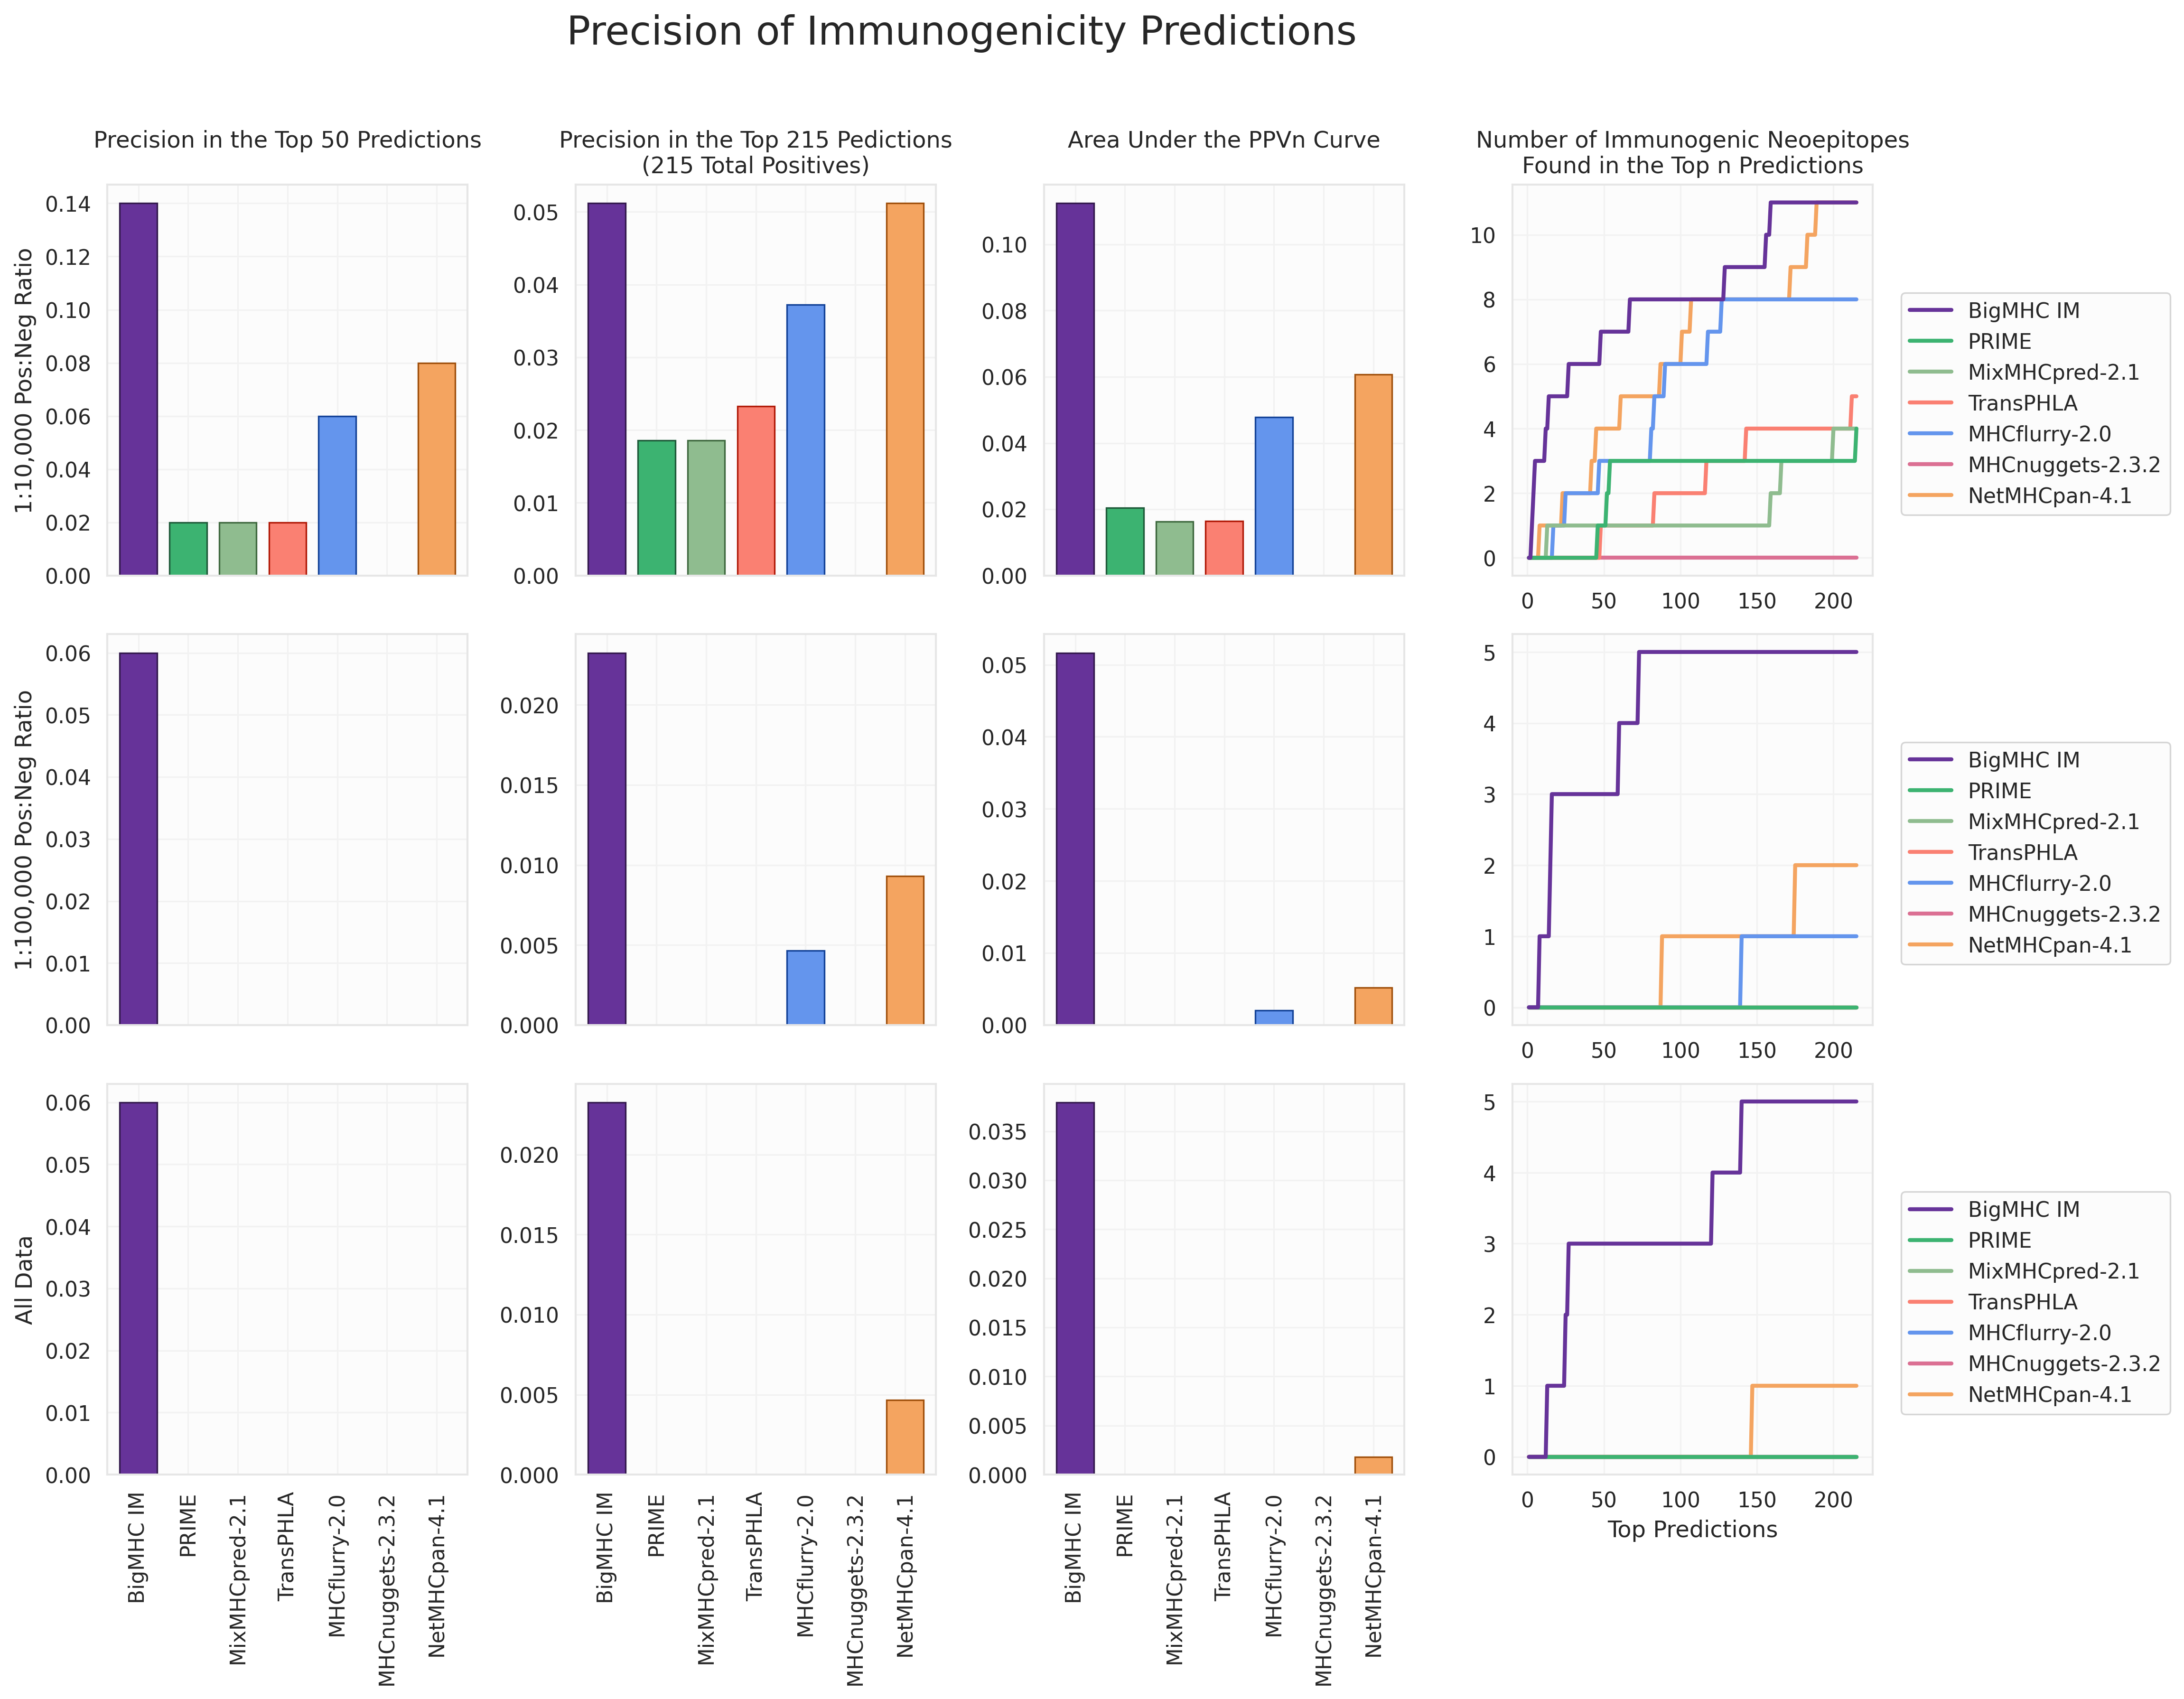

In [7]:
import numpy as np


def plotPPV(ax, df, ylabel, settitle=False, setxlabels=False, setlegend=False):
    
    order = [
        "bigmhc_im",
        "prime",
        "mixmhcpred",
        "transphla",
        "mhcflurry",
        "mhcnuggets",
        "netmhcpan"]
        
    ppv50 = list()
    ppvn  = list()
    auppv = list()
    
    T = df["tgt"]
    tsum = int(T.sum())
    
    for col in order[::-1]:
        if col not in df.columns:
            continue
        P = df[col]
        idx = np.argsort(P)[::-1]
        
        ppv50.append([methods[col], T[idx[:50]].sum() / 50])
        ppvn.append([methods[col], T[idx[:tsum]].sum() / tsum])
        auppv.append([methods[col], metrics.auc(
            np.linspace(0,1,tsum),
            np.cumsum(T[idx[:tsum]]) / np.arange(1,tsum+1))])
        
        x = np.arange(1,tsum+1)
        y = np.cumsum(T[idx[:tsum]])
        
        ax[3].plot(x,y,color=colors[methods[col]],linewidth=2,label=methods[col])
    
    bbox = (1.05, 0.75)
    ax[3].legend(bbox_to_anchor=bbox)
    
    hdl, lbl = ax[3].get_legend_handles_labels()
    ax[3].legend(hdl[::-1], lbl[::-1], bbox_to_anchor=bbox)
    
    if setlegend:
        ax[3].legend(labelspacing=3)
    
    ppv50 = pd.DataFrame(columns=["Method","PPVn"], data=ppv50[::-1])
    ppvn = pd.DataFrame(columns=["Method","PPVn"], data=ppvn[::-1])
    auppv = pd.DataFrame(columns=["Method","AUPPVn"], data=auppv[::-1])
    
    dfs = [ppv50, ppvn, auppv]
    
    barcolors = [colors[methods[x]] for x in order if x in df.columns]
    for x in range(len(dfs)):
        dfs[x].plot.bar(
            ax=ax[x],
            x="Method",
            y=dfs[x].columns[1],
            legend=None,
            color=barcolors,
            width=0.75)
    
    for a in ax[:3]:
        for rect in a.patches:
            rgb = rect.get_facecolor()[:3]
            hls = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
            rect.set_edgecolor(colorsys.hls_to_rgb(hls[0], hls[1]/2, hls[2]))
    
    ax[0].set_ylabel(ylabel)
    
    if settitle:
        ax[0].set_title("Precision in the Top 50 Predictions\n")
        ax[1].set_title("Precision in the Top {} Pedictions\n({} Total Positives)".format(tsum, tsum))
        ax[2].set_title("Area Under the PPVn Curve\n")
        ax[3].set_title("Number of Immunogenic Neoepitopes\nFound in the Top n Predictions")
    
    if setxlabels:
        ax[3].set_xlabel("Top Predictions")
    else:
        for x in range(3):
            ax[x].set(xticklabels=[])
    for x in range(3):
        ax[x].set(xlabel=None)


def sampleNeo(ratio):
    neg.reset_index(drop=True, inplace=True)
    pos = ifng["tgt"].sum() + manafest["tgt"].sum()
    total = neg.shape[0] + ifng.shape[0] + manafest.shape[0]
    if ratio:
        negsamp = neg[neg.index % int(total / (ratio*pos)) == 0]
    else:
        negsamp = neg
    return pd.concat((ifng, manafest, negsamp)).reset_index(drop=True)


with sns.axes_style(style=style, rc=rc):

    neofig = plt.figure(figsize=(16,12), dpi=300)

    gs = neofig.add_gridspec(nrows=3, ncols=4, hspace=0.15, wspace=0.30)
    ax = gs.subplots()
    
    df = sampleNeo(10000)
    plotPPV(ax[0], df, ylabel="1:10,000 Pos:Neg Ratio", settitle=True)
    
    df = sampleNeo(100000)
    plotPPV(ax[1], df, ylabel="1:100,000 Pos:Neg Ratio")
    
    df = sampleNeo(0)
    plotPPV(ax[2], df, ylabel="All Data", setxlabels=True)
    
    neofig.suptitle("Precision of Immunogenicity Predictions", fontsize=20)
    
    neofig.savefig(os.path.join(savedir,"immuno_precision.png" ), bbox_inches="tight")

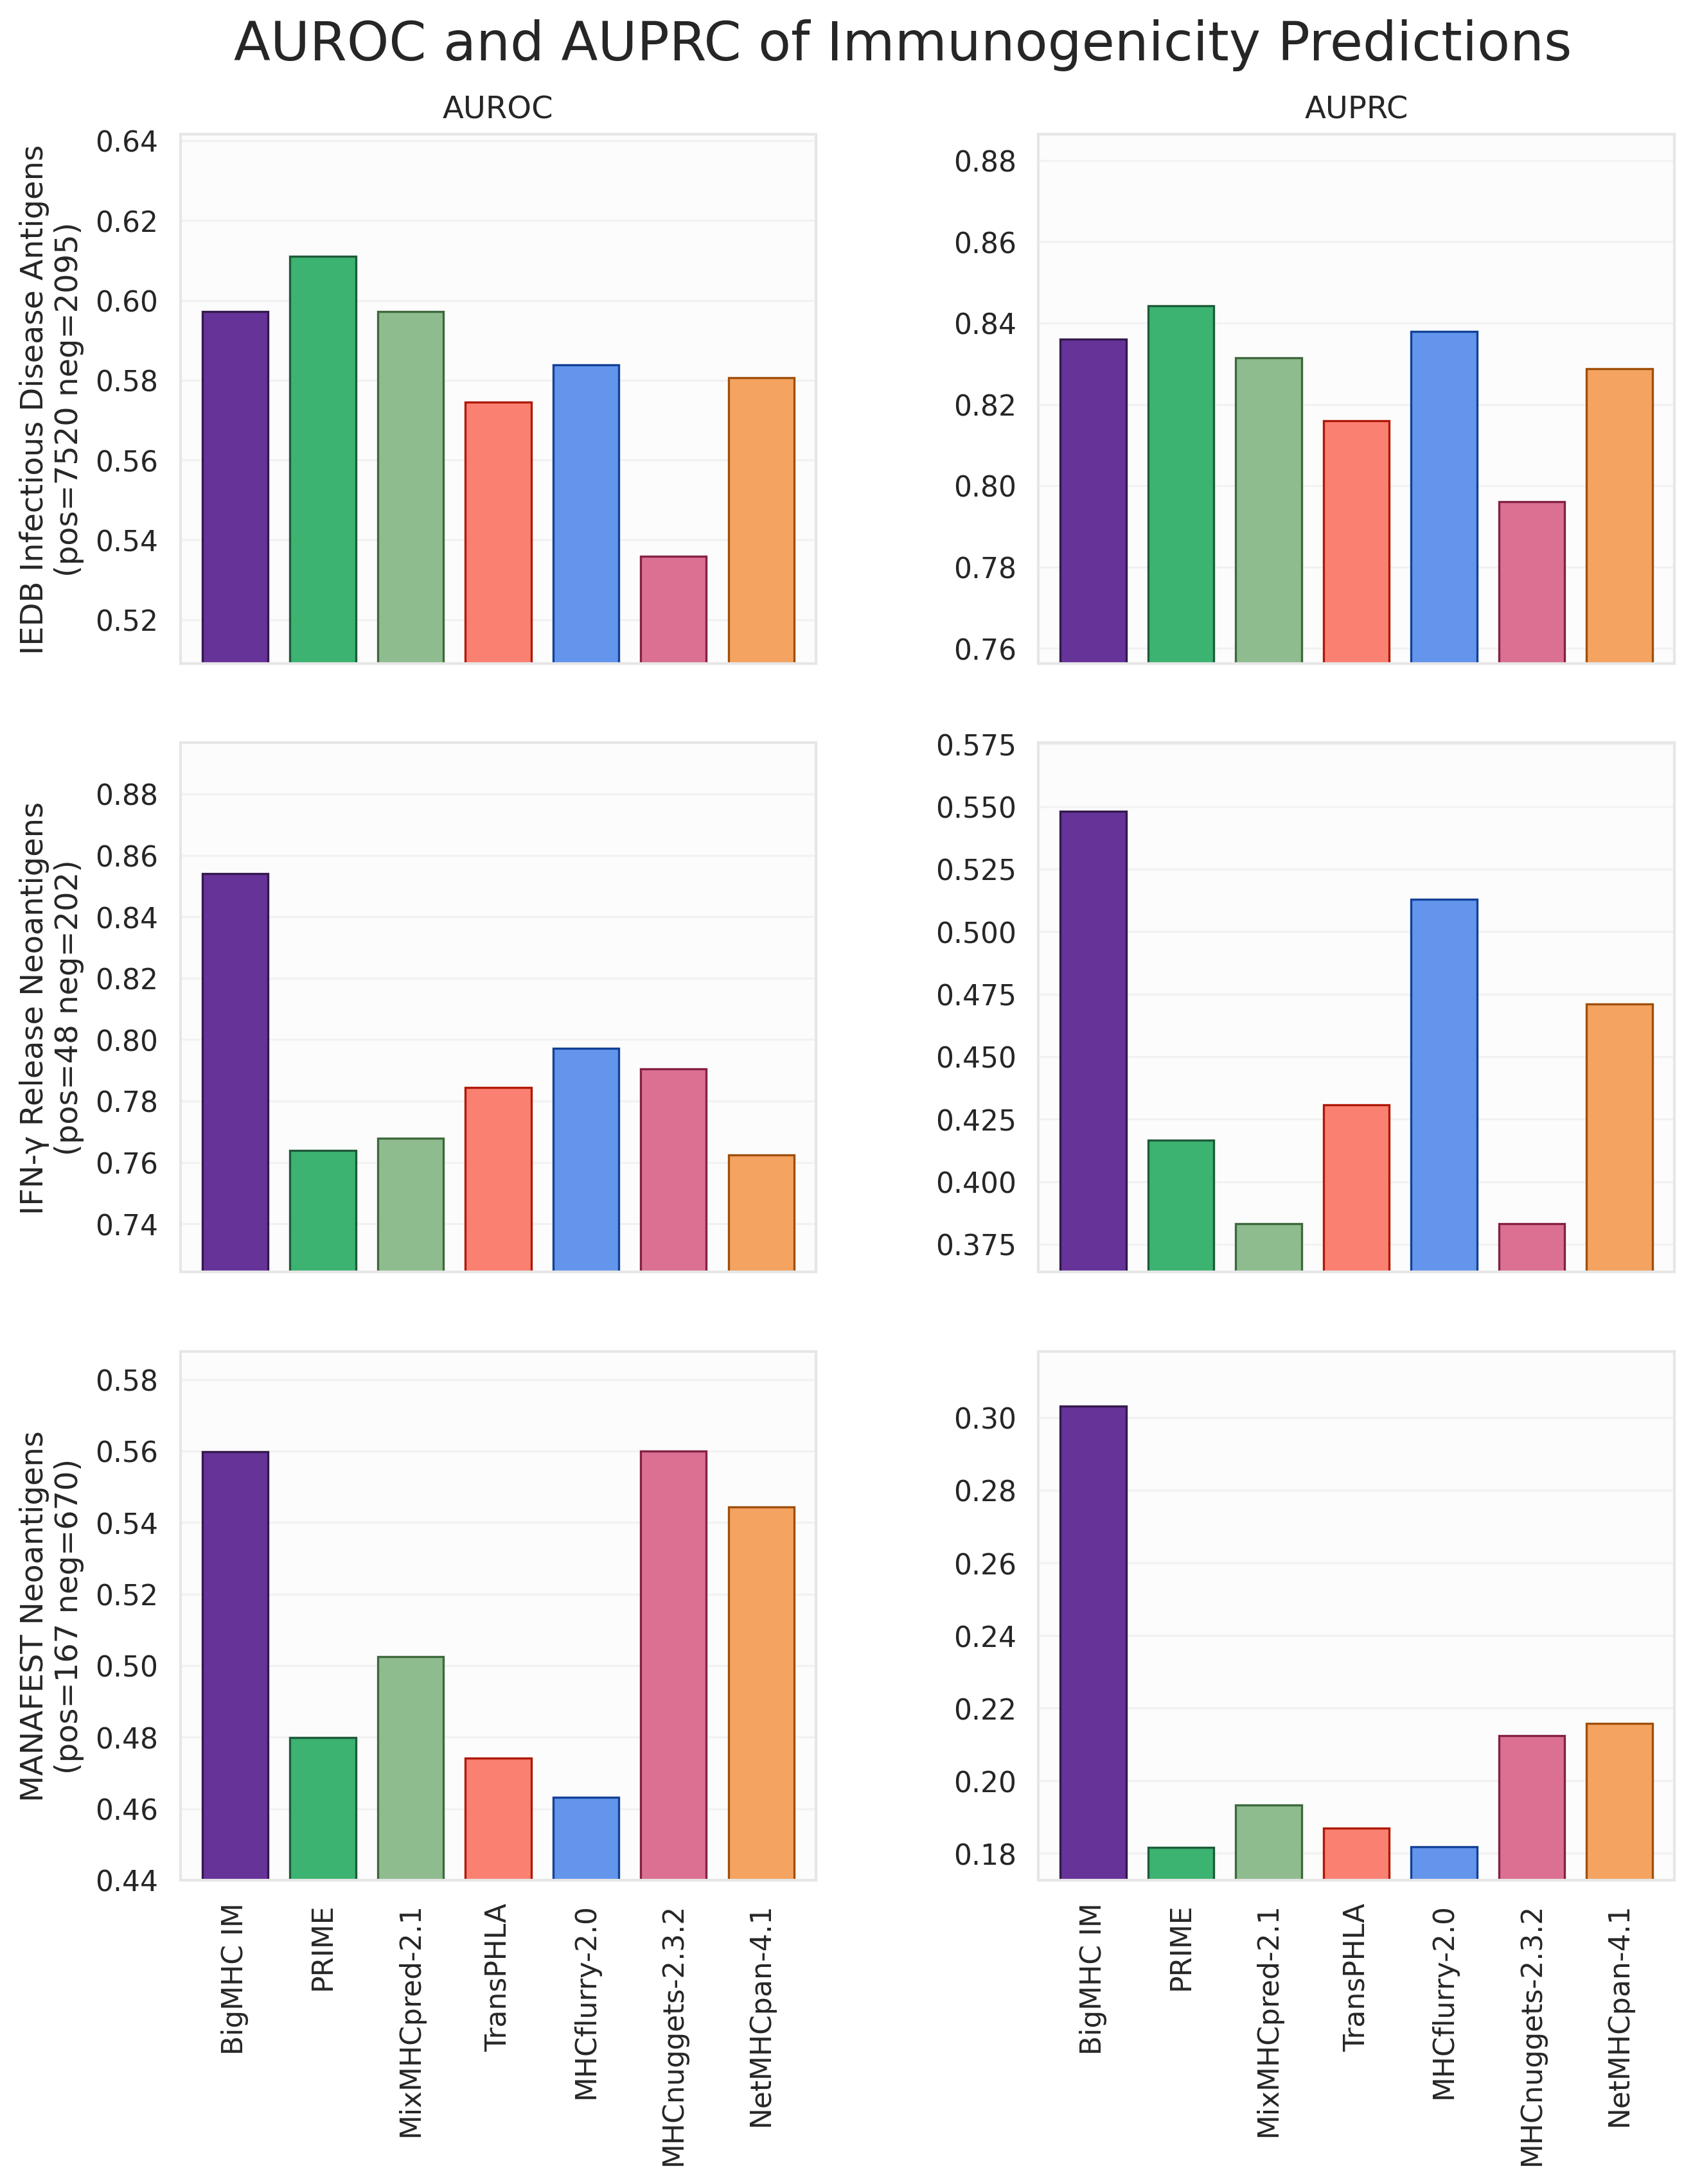

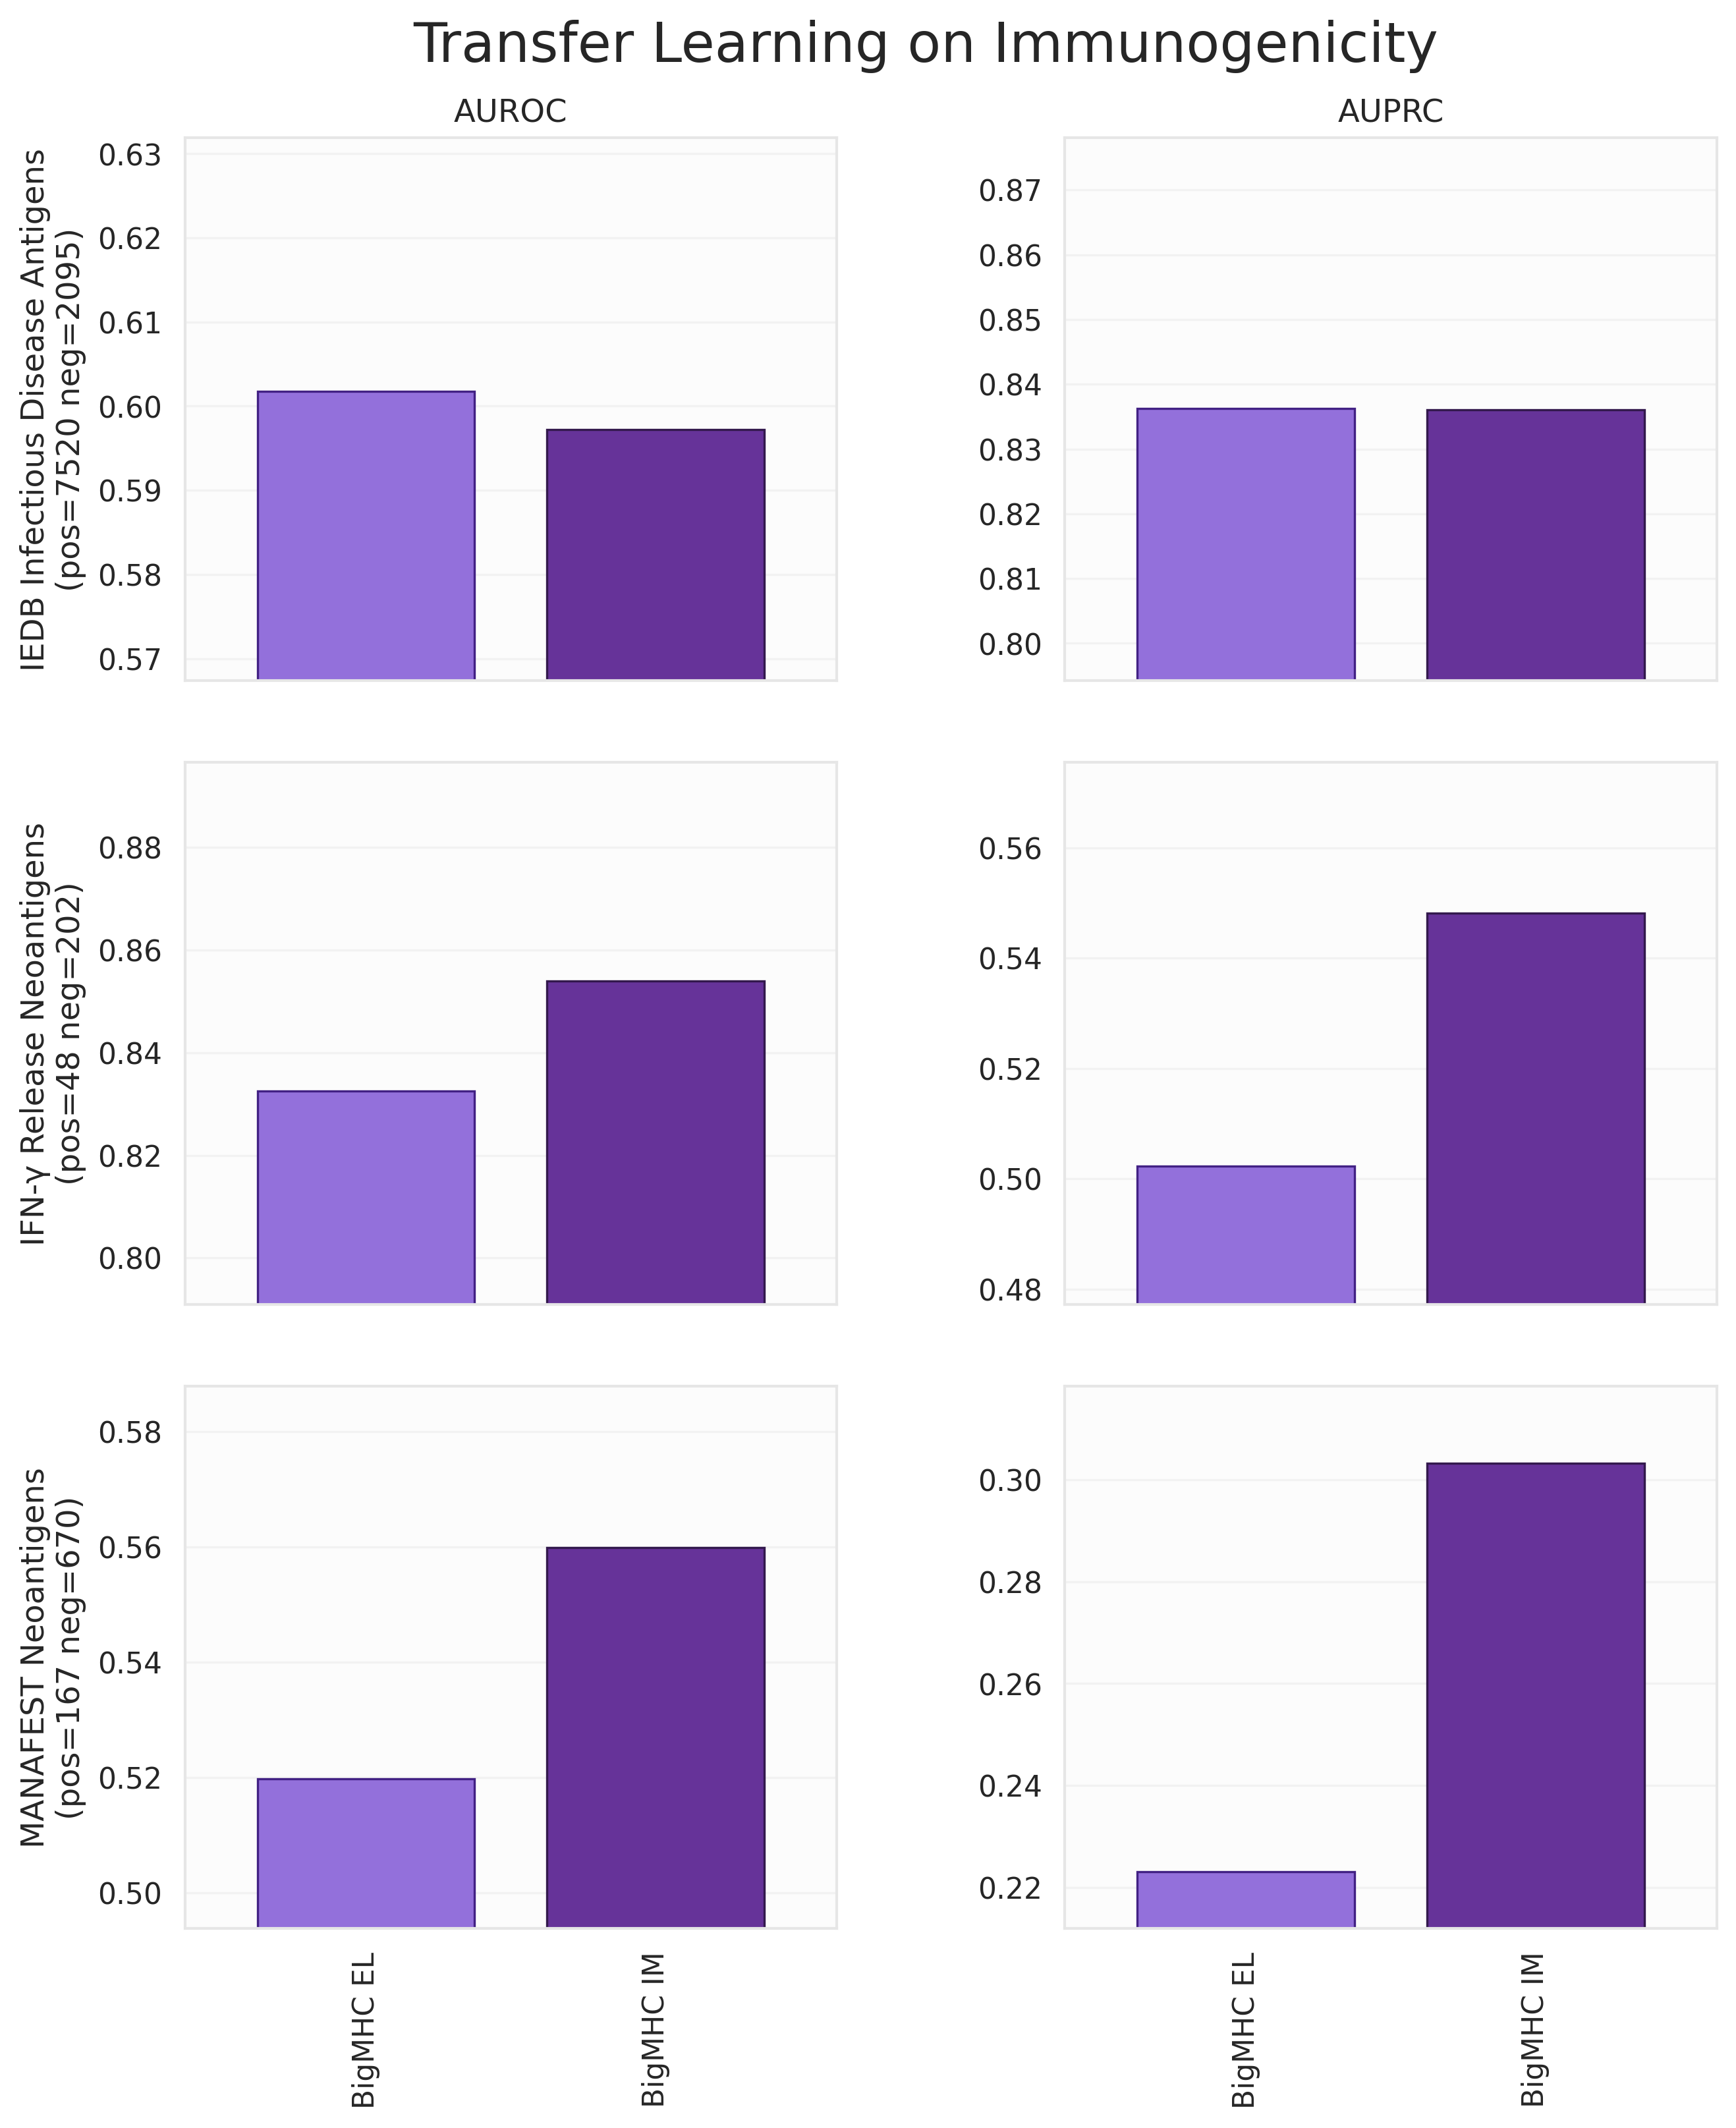

In [6]:
def plotImmunoBars(ax, df, order, ylabel, setlabels=False):
    
    ylabel = ylabel + "\n(pos={} neg={})".format(df["tgt"].sum(), df.shape[0]-df["tgt"].sum())
    
    results = list()
    for col in order:
        if col not in df.columns:
            continue
        roc = metrics.roc_auc_score(df["tgt"], df[col])
        prc = auprc(df["tgt"], df[col])
        results.append([methods[col], roc, prc])
    results = pd.DataFrame(columns=["Method","AUROC","AUPRC"], data=results)
    
    barcolors = [colors[methods[x]] for x in order if x in df.columns]
    results.plot.bar(ax=ax[0], x="Method", y="AUROC", legend=None, color=barcolors, width=0.75)
    results.plot.bar(ax=ax[1], x="Method", y="AUPRC", legend=None, color=barcolors, width=0.75)
    
    for a in ax:
        for rect in a.patches:
            rgb = rect.get_facecolor()[:3]
            hls = colorsys.rgb_to_hls(rgb[0], rgb[1], rgb[2])
            rect.set_edgecolor(colorsys.hls_to_rgb(hls[0], hls[1]/2, hls[2]))
    
    ax[0].set_xlabel(None)
    ax[1].set_xlabel(None)
    
    ax[0].set_ylabel(ylabel)
    
    ax[0].set_ylim(0.95*results["AUROC"].min())
    ax[1].set_ylim(0.95*results["AUPRC"].min())
    
    ax[0].grid(axis='x')
    ax[1].grid(axis='x')
    
    if setlabels:
        ax[0].set_title("AUROC")
        ax[1].set_title("AUPRC")


def plotImmuno(dfs, titles, suptitle, supp=False):
    
    if supp:
        order = [
            "bigmhc_el",
            "bigmhc_im"]
    else:
        order = [
            "bigmhc_im",
            "prime",
            "mixmhcpred",
            "transphla",
            "mhcflurry",
            "mhcnuggets",
            "netmhcpan"]

    immunobars = plt.figure(figsize=(10,12), dpi=300)

    gs = immunobars.add_gridspec(nrows=len(dfs), ncols=2, wspace=0.35, hspace=0.15)
    ax = gs.subplots(sharex="col")
    
    for x in range(len(dfs)):
        plotImmunoBars((ax[x][0],ax[x][1]), dfs[x], order, titles[x], setlabels=(x==0))

    immunobars.suptitle(suptitle, fontsize=20, y=0.93)
    
    return immunobars


with sns.axes_style(style=style, rc=rc):
    fig = plotImmuno(
        [iedb, ifng, manafest],
        ["IEDB Infectious Disease Antigens", "IFN-γ Release Neoantigens", "MANAFEST Neoantigens"],
        "AUROC and AUPRC of Immunogenicity Predictions")
    fig.savefig(os.path.join(savedir,"immuno.png" ), bbox_inches="tight")
    fig = plotImmuno(
        [iedb, ifng, manafest],
        ["IEDB Infectious Disease Antigens", "IFN-γ Release Neoantigens", "MANAFEST Neoantigens"],
        "Transfer Learning on Immunogenicity",
        supp=True)
    fig.savefig(os.path.join(savedir,"immuno_supplemental.png" ), bbox_inches="tight")